In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils import data
from normflow import MAF, BatchNorm, Reverse, NormFlowDE

from sklearn import datasets
import time
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cpu')

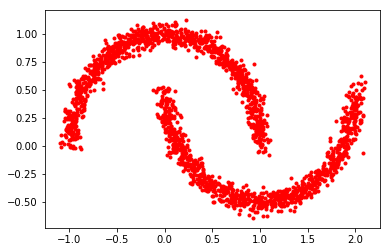

In [3]:
################################### MAF example dataset
# def drawP(n):
#     x2_dist = dist.Normal(0, 4)
#     x2 = x2_dist.sample((n,))
#     x1_dist = dist.Normal(.25 * x2.pow(2), torch.ones_like(x2))
#     x1 = x1_dist.sample()
#     x = torch.stack([x1, x2], dim=1)
#     return x
# N = 8000
# X = drawP(N).to(device)
# plt.plot(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], ".r")
################################### MAF example dataset

################################### moon dataset
N = 8000
X = datasets.make_moons(n_samples=N, noise=.05)[0]
X = torch.tensor(X, dtype=torch.float32).to(device)
plt.plot(X.cpu().numpy()[:2000, 0], X.cpu().numpy()[:2000, 1], ".r")
################################### moon dataset

################################### SIG dataset
# import pickle
# import numpy as np
# with open('siggraph.pkl', 'rb') as f:
#     X = np.array(pickle.load(f))
# X -= np.mean(X, axis=0)  # center
# xlim, ylim = [-4, 4], [-2, 2]
# X = torch.tensor(X, dtype=torch.float32).to(device)
# N = X.size(0)
# plt.plot(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], ".r")
################################### SIG dataset

In [8]:
trainLoader = data.DataLoader(dataset=X, batch_size=200, shuffle=True)

def halve_lr_(optimizer, factor=0.5):
    for param in optimizer.param_groups:
        param['lr'] *= factor

def train(epochs, m, optimizer):
    tic = time.time()
    for epoch in range(epochs):
        epoch_loss = 0
        for x in trainLoader:
            loss = -m(x).mean()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(m.parameters(), 0.1)
            optimizer.step()
            epoch_loss += loss.item() * x.shape[0]
        # if epoch > 0 and epoch % 1000 == 0:
        #     halve_lr_(optimizer, 0.5)
        if epoch % 20 == 0:
            print("Epoch: {} Loss: {}".format(epoch, epoch_loss/N))
    print("Time passed: {}s".format(time.time()-tic))

In [9]:
D, hs = 2, [100, 100]
transforms = []
for _ in range(5):
    transforms += [MAF(D, hs), Reverse(D)]
μ, Σ = torch.ones(D).to(device), torch.eye(D).to(device)
m = NormFlowDE(μ, Σ, list(reversed(transforms))).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-4, amsgrad=True)

In [10]:
train(140+1, m, optimizer)

Epoch: 0 Loss: 2.327873232960701
Epoch: 20 Loss: 0.8620624735951423
Epoch: 40 Loss: 0.6678191468119621
Epoch: 60 Loss: 0.5106945641338825
Epoch: 80 Loss: 0.41529378667473793
Epoch: 100 Loss: 0.36798442490398886
Epoch: 120 Loss: 0.3608612738549709
Epoch: 140 Loss: 0.34351498261094093
Time passed: 67.18539690971375s


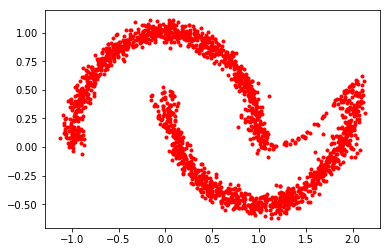

In [11]:
x = m.sample(2000)
plt.plot(x.cpu().numpy()[:, 0], x.cpu().numpy()[:, 1], ".r")